<a href="https://colab.research.google.com/github/pejmanrasti/NLP/blob/main/3_MLP_surname_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Layer Perceptron (MLP) for Surname Nationality Classification

This notebook demonstrates how to build and train a Multi-Layer Perceptron (MLP) to classify surnames based on their nationalities using a dataset of surnames and corresponding nationalities.

In [1]:
import tensorflow as tf
import keras
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

2023-12-05 14:17:42.312039: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 14:17:42.343331: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 14:17:42.343359: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 14:17:42.344341: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 14:17:42.349981: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-05 14:17:42.350521: I tensorflow/core/platform/cpu_feature_guard.cc:1

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical

## Step 2: Load and Preprocess the Data

The dataset is loaded into a Pandas DataFrame. We need to preprocess this data for our neural network.

In [3]:
# Load the dataset
file_path = 'surnames.csv'
surnames_data = pd.read_csv(file_path)

# Display the first few rows
surnames_data.head()

,surname,nationality
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian


### Data Preprocessing

We need to encode the surnames and nationalities into a numerical format. For surnames, we'll convert each character to its ASCII value. For nationalities, we use label encoding.

In [4]:

# Creating a character set and mapping characters to integers
characters = sorted(list(set(''.join(surnames_data['surname']))))
char_to_int = dict((c, i) for i, c in enumerate(characters))

# Function to convert surname to a sequence of integers
def surname_to_int_array(surname):
    return [char_to_int[char] for char in surname if char in char_to_int]

# Convert surnames to sequences of integers
surnames_data['surname_seq'] = surnames_data['surname'].apply(surname_to_int_array)

# Find the length of the longest surname
max_surname_length = max(surnames_data['surname_seq'].apply(len))

# Pad the sequences so that they are all the same length
from keras.preprocessing.sequence import pad_sequences
surnames_data['surname_padded'] = list(pad_sequences(surnames_data['surname_seq'], maxlen=max_surname_length, padding='post'))

# Convert the padded sequences and labels to numpy arrays for training
X = np.array(surnames_data['surname_padded'].tolist())


In [5]:
# Label encode nationalities
label_encoder = LabelEncoder()
surnames_data['nationality_encoded'] = label_encoder.fit_transform(surnames_data['nationality'])

In [6]:
# Label encode nationalities
label_encoder = LabelEncoder()
surnames_data['nationality_encoded'] = label_encoder.fit_transform(surnames_data['nationality'])
# One-hot encode the nationality labels
y = to_categorical(surnames_data['nationality_encoded'])

## Step 3: Split the Data

We split the data into training, validation, and test sets.

In [7]:

# Stratified Split of the Data
# We use stratified split to ensure representation of each nationality in all datasets

from sklearn.model_selection import StratifiedShuffleSplit

# Creating a StratifiedShuffleSplit object
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Splitting the data - this will only do one split due to n_splits=1
for train_index, temp_index in strat_split.split(X, surnames_data['nationality_encoded']):
    X_train, X_temp = X[train_index], X[temp_index]
    y_train, y_temp = y[train_index], y[temp_index]

# Further split X_temp and y_temp into validation and test sets
strat_split_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in strat_split_val_test.split(X_temp, y_temp.argmax(axis=1)):
    X_val, X_test = X_temp[val_index], X_temp[test_index]
    y_val, y_test = y_temp[val_index], y_temp[test_index]


## Step 4: Build the MLP Model

We build a simple MLP model using Keras.

In [8]:
# Update the MLP model to include an Embedding layer
from keras.layers import Embedding

# Define the model
model = Sequential()
model.add(Embedding(input_dim=len(characters), output_dim=50, input_length=max_surname_length))
model.add(Flatten())  # Flatten the output of the embedding layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 50)            4200      
                                                                 
 flatten (Flatten)           (None, 850)               0         
                                                                 
 dense (Dense)               (None, 128)               108928    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 18)                1170      
                                                                 
Total params: 122554 (478.73 KB)
Trainable params: 12255

## Step 5: Train the Model

We train the model using the training set and validate it on the validation set.

In [9]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
241/241 [==============================] - 1s 3ms/step - loss: 2.0695 - accuracy: 0.4023 - val_loss: 1.7001 - val_accuracy: 0.5124
Epoch 2/50
241/241 [==============================] - 0s 2ms/step - loss: 1.5944 - accuracy: 0.5497 - val_loss: 1.4519 - val_accuracy: 0.5695
Epoch 3/50
241/241 [==============================] - 1s 2ms/step - loss: 1.3935 - accuracy: 0.5994 - val_loss: 1.3077 - val_accuracy: 0.6163
Epoch 4/50
241/241 [==============================] - 0s 2ms/step - loss: 1.2525 - accuracy: 0.6379 - val_loss: 1.2229 - val_accuracy: 0.6327
Epoch 5/50
241/241 [==============================] - 0s 2ms/step - loss: 1.1653 - accuracy: 0.6590 - val_loss: 1.1430 - val_accuracy: 0.6594
Epoch 6/50
241/241 [==============================] - 0s 2ms/step - loss: 1.0776 - accuracy: 0.6801 - val_loss: 1.0849 - val_accuracy: 0.6849
Epoch 7/50
241/241 [==============================] - 1s 2ms/step - loss: 1.0081 - accuracy: 0.7015 - val_loss: 1.0579 - val_accuracy: 0.6861
Epoch 

Matplotlib is building the font cache; this may take a moment.


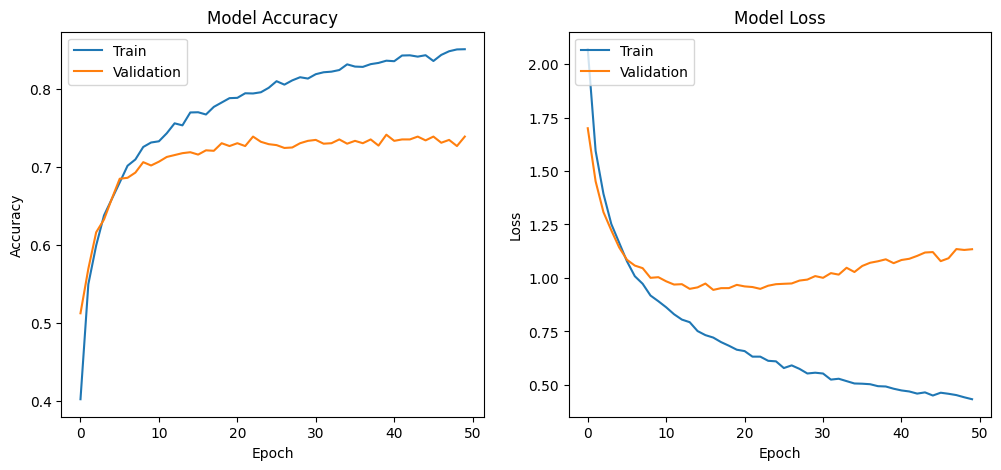

In [12]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Step 6: Evaluate the Model

Evaluate the model's performance on the test set.

In [10]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

52/52 [==============================] - 0s 1ms/step - loss: 1.0880 - accuracy: 0.7371
Test Accuracy: 73.71%


In [15]:
model.predict(X_train)

241/241 [==============================] - 0s 901us/step


array([[2.9507409e-37, 1.3598843e-19, 5.8355351e-07, ..., 2.2870039e-10,
        1.9134409e-11, 3.5433234e-17],
       [9.1321213e-12, 8.3267042e-07, 1.0642703e-02, ..., 1.3216074e-03,
        1.6935378e-04, 2.5808998e-07],
       [2.4726282e-13, 1.6847588e-09, 1.0569254e-04, ..., 5.2744109e-04,
        1.3533257e-02, 1.7363675e-08],
       ...,
       [1.6487080e-12, 4.1891419e-04, 1.8426007e-02, ..., 2.3618396e-02,
        1.2321918e-03, 7.8381912e-05],
       [4.5013341e-33, 1.0131566e-19, 1.6618301e-07, ..., 8.1721087e-15,
        9.9310338e-17, 3.9975720e-18],
       [1.0222536e-29, 3.4042893e-20, 2.1471215e-11, ..., 1.4642901e-06,
        2.1520062e-17, 1.1978450e-17]], dtype=float32)

In [89]:
#Prepocess Example à prédire

topredict=['Thierry','François','Jean','Natasha','Jean-Benoit','Sylvie','Karl','Ingo','Gerd']
topredict=surnames_data['surname']
def preprocess(liste):
    tpdata=pd.DataFrame(pd.DataFrame({'surname': np.array(liste)}))
    tpdata['surname_seq'] = tpdata['surname'].apply(surname_to_int_array)
    from keras.preprocessing.sequence import pad_sequences
    tpdata['surname_padded'] = list(pad_sequences(tpdata['surname_seq'], maxlen=max_surname_length, padding='post'))
    Xtp=np.array(tpdata['surname_padded'].tolist())
    return Xtp,tpdata
    
#tpdata=pd.DataFrame(pd.DataFrame({'surname': np.array(['Thierry','Charles'])}))
#tpdata['surname_seq'] = tpdata['surname'].apply(surname_to_int_array)
#from keras.preprocessing.sequence import pad_sequences
#tpdata['surname_padded'] = list(pad_sequences(tpdata['surname_seq'], maxlen=max_surname_length, padding='post'))
#print(tpdata)
#Xtp=np.array(tpdata['surname_padded'].tolist())

Xtp,tpdata=preprocess(topredict)

In [90]:
predicted_probabilities=model.predict(Xtp)
# Get the predicted class
predicted_class = np.argmax(predicted_probabilities, axis=1)



def wLabel(liste):
    return label_encoder.inverse_transform(liste)

tpdata["predicted_class"]=wLabel(predicted_class).transpose()

#print(topredict,'\t Data')
#print(wLabel(predicted_class),'\t Predicted')

tpdata[['surname','predicted_class']]


344/344 [==============================] - 0s 889us/step


,surname,predicted_class
0,Woodford,English
1,Coté,French
2,Kore,English
3,Koury,Arabic
4,Lebzak,Russian
...,...,...
10975,Quraishi,Arabic
10976,Innalls,English
10977,Król,Polish
10978,Purvis,English


In [102]:
#topredict=['Mustermann','Eberwein','Schrek','Schumacher','Philippi','Schotte','Schmitz','Dupont','Leblanc']
topredict=['Al Baroudi','Van Forest','Siu','Jando','Rilke','Remarque','Créquy','Jussien','Lefort']
#topredict=surnames_data['surname']

def fancy_p(modele,liste):
    tpdata=pd.DataFrame(pd.DataFrame({'surname': np.array(liste)}))
    tpdata['surname_seq'] = tpdata['surname'].apply(surname_to_int_array)
    from keras.preprocessing.sequence import pad_sequences
    tpdata['surname_padded'] = list(pad_sequences(tpdata['surname_seq'], maxlen=max_surname_length, padding='post'))
    Xtp=np.array(tpdata['surname_padded'].tolist())

    predicted_probabilities=model.predict(Xtp)
    predicted_class = np.argmax(predicted_probabilities, axis=1)
    predicted_probabilities1=np.copy(predicted_probabilities)
    for i, idx in enumerate(predicted_class):
        predicted_probabilities1[i, idx] = 0
    predicted_class2 = np.argmax(predicted_probabilities1, axis=1)
    predict_mp = np.max(predicted_probabilities, axis=1)
    predict_mp2 = np.max(predicted_probabilities1, axis=1)
    
    tpdata["predicted_class"]=label_encoder.inverse_transform(predicted_class).transpose()
    tpdata["proba"]=predict_mp
    
    tpdata["predicted_class2"]=label_encoder.inverse_transform(predicted_class2).transpose()
    tpdata["proba2"]=predict_mp2
    
    print(tpdata[['surname','predicted_class','proba','predicted_class2','proba2']])
    return tpdata

fp=fancy_p(model,topredict)

1/1 [==============================] - 0s 14ms/step
      surname predicted_class     proba predicted_class2    proba2
0  Al Baroudi         Italian  0.982628         Japanese  0.017046
1  Van Forest          French  0.908376          English  0.058987
2         Siu         Chinese  0.820178       Vietnamese  0.120019
3       Jando           Czech  0.292786          Russian  0.289820
4       Rilke         English  0.677061          Russian  0.203212
5    Remarque         English  0.460403           French  0.420352
6      Créquy         Italian  0.774481          Spanish  0.194749
7     Jussien         English  0.652938          Russian  0.255454
8      Lefort         English  0.919521           French  0.056014


### X_train

## Step 7: Save the Model (Optional)

Optionally, we can save the model for future use.

In [11]:
# Save the model
model.save('surname_nationality_classifier.h5')

/users/2024/ds2/122000483/.local/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TODO: Give a surname to the model and ask the model to predict the nationality of it.

TODO: change the architecture of the model to reduce the overfitting